In [1]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats

home_dir = os.getenv("HOME")

#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [102]:
filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
start_date = '2016-07-01'
end_date = '2016-08-30'
tempDF = tempDF[start_date:end_date][meta['location:Longitude'].dropna().index].drop(41,axis=1)
meta =meta.loc[tempDF.columns]
# remember to subtract bias

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [115]:
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
nchunks = 20
df = pd.DataFrame( columns=analysis_points.index, index = [file[-19:] for file in files])
n = 0
for i in range(nchunks):
    dataset_list = []
    for file in files[n,n+len(files)/nchunks]: 
        dataset_list.append(Dataset(file))

    t2 = getvar(dataset_list, varname = "T2", 
              timeidx = wrf.ALL_TIMES, 
              method = 'cat'
              )
    # convert to degrees C
    t2 = t2 - 273.15
    pts = wrf.ll_to_xy(dataset_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
    #data = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    df.loc[files[n][-19:], files[n+len(files)/nchunks][-19:]] = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    n= n+len(files)/nchunks
    
df.to_csv('%s_%s_allpoints.csv'%(exp,dom))
lc = getvar(dataset_list[-1], "LU_INDEX")
lc.to_csv('%s_%s_landcover.csv'%(exp,dom))

In [ ]:
# do in python
import pandas as pd
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
import os
import glob
import numpy as np

filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
start_date = '2016-07-01'
end_date = '2016-08-30'
tempDF = tempDF[start_date:end_date][meta['location:Longitude'].dropna().index].drop(41,axis=1)
meta =meta.loc[tempDF.columns]

home_dir = os.getenv("HOME")
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
nchunks = 20
df = pd.DataFrame( columns=analysis_points.index, index = [file[-19:] for file in files])
n = 0
for i in range(nchunks):
    dataset_list = []
    for file in files[n:n+(len(files)/nchunks)]: 
        dataset_list.append(Dataset(file))

    t2 = getvar(dataset_list, varname = "T2", 
              timeidx = wrf.ALL_TIMES, 
              method = 'cat'
              )
    # convert to degrees C
    t2 = t2 - 273.15
    pts = wrf.ll_to_xy(dataset_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
    #data = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    df.loc[files[n][-19:]:files[n+len(files)/nchunks-1][-19:],:] = np.diagonal(t2.isel(west_east = pts.values[0], south_north = pts.values[1]), axis1=1,axis2=2)
    n= n+len(files)/nchunks
    for ds in dataset_list: 
        ds.close()
    t2.close()
    df.to_csv('data/%s_%s_allpoints.csv'%(exp,dom))

df.to_csv('data/%s_%s_allpoints.csv'%(exp,dom))


In [304]:
lc = getvar(dataset_list[-1], "LU_INDEX").isel(west_east = pts.values[0], south_north = pts.values[1])
lcc = pd.DataFrame(np.diag(lc), index = df.columns, columns=['LCC'])
lcc['LCC English'] =  [lcc_english[int(x)]for x in lcc.LCC]
lcc.to_csv('data/%s_%s_landcover.csv'%(exp,dom))

In [150]:
np.diagonal(t2.isel(west_east = pts.values[0], south_north = pts.values[1]), axis1=1,axis2=2)

(24, 85)

In [58]:
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

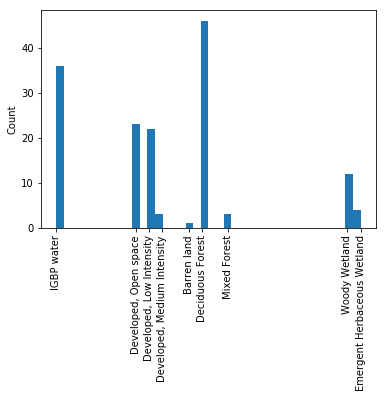

In [71]:
patches = plt.hist(np.diag(lc), bins = 40)
markers = plt.xticks(np.unique(np.diag(lc)),
                     [lcc_english[int(x)]for x in np.unique(np.diag(lc))], rotation='vertical')
plt.ylabel('Count')

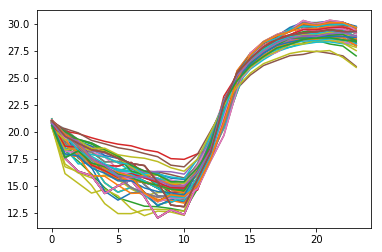

In [43]:
for i in range(len(analysis_points)):
    plt.plot(data[:,i,i])

In which run has largest UHI, we saw that the UCM 6am run has largest UHI

# Compute error statistics

RMSE, correlation, bias, hit rate, index of agreement, and coefficient of determination

In [322]:
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)

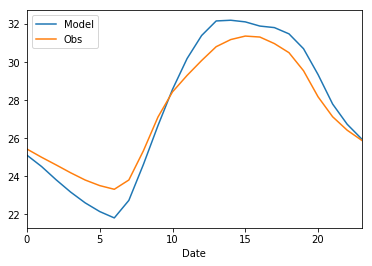

In [282]:
model.groupby(model.index.hour).mean().mean(axis=1).plot()
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).plot()
plt.legend(['Model', 'Obs'],loc=2)

In [242]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# coefficient of determination: r**2
# hit rate 
def pbias(obs, sim): 
    return 100*(sim-obs).sum()/(obs).sum()
# index of agreement
def mioa(obs,sim,  j =2): 
    return 1 - (((obs-sim)**j).sum())/( (abs(sim-obs.mean())+abs(obs-obs.mean()))**j).sum() 

In [286]:
# make sure it's for the same dates
# make sure that tempDF and meta are indexed in the same order
stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])

# all data 
obs = tempDF.mean().values
sim = model.mean().values
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF[tempDF.index.hour ==hr].mean().values
    sim = model[model.index.hour==hr].mean().values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

stats_df
# # pretty print latex table : 
# vars = [rmse,correlation[0]]
# labels = ['RMSE', 'r']
# for var, label in zip(vars,labels): 
#     print('%s & %2.2f \\\\'%(label,var))

,all data,6,16
rmse,8.181977e-01,3.313241e+00,3.653377
correlation,6.931034e-01,5.430354e-01,0.480766
p-value,1.974532e-13,7.897980e-08,0.000003
pbias,2.671038e-01,-6.451190e+00,1.841714
mioa,7.217172e-01,5.571342e-01,0.430299
r_squared,4.803924e-01,2.948874e-01,0.231136


In [287]:
print(stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

\begin{tabular}{lrrr}
\toprule
{} &  all data &     6 &   16 \\
\midrule
rmse        &      0.82 &  3.31 & 3.65 \\
correlation &      0.69 &  0.54 & 0.48 \\
p-value     &      0.00 &  0.00 & 0.00 \\
pbias       &      0.27 & -6.45 & 1.84 \\
mioa        &      0.72 &  0.56 & 0.43 \\
r\_squared   &      0.48 &  0.29 & 0.23 \\
\bottomrule
\end{tabular}



In [ ]:
# ['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City']
selected_pts = [] # probably: developed low intensity, developed medium intensity 

# Diurnal cycle 

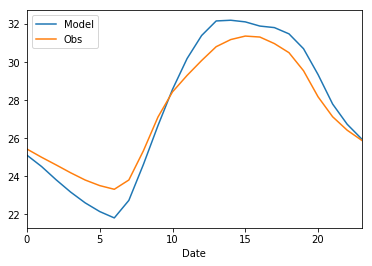

In [285]:
model.groupby(model.index.hour).mean().mean(axis=1).plot()
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).plot()
plt.legend(['Model', 'Obs'],loc=2)

In [327]:
lc = 23

In [330]:
lcc_english[lc]

'Developed, Open space'

In [329]:
lcc.head()

,LCC,LCC English
82,23.0,"Developed, Open space"
139,25.0,"Developed, Medium Intensity"
130,28.0,Deciduous Forest
32,23.0,"Developed, Open space"
10,26.0,"Developed, High Intensity"


In [387]:
model[lcc[lcc.LCC ==lc].index].shape[1]

8

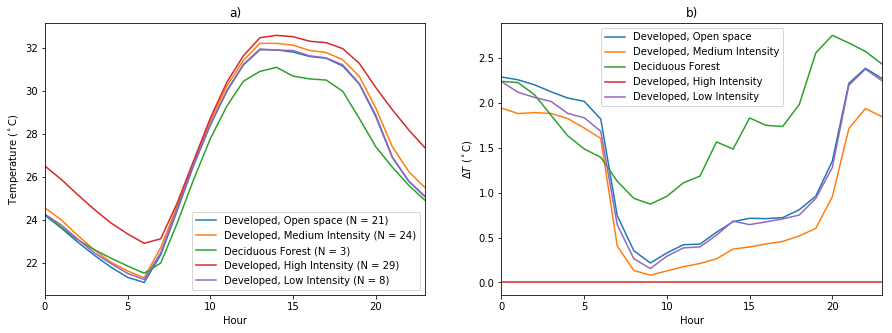

In [388]:
plt.figure(figsize = [15,5])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
#plot temp
ax = plt.subplot(1,2,1)
for lc in lcc.LCC.unique():
    model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    
plt.legend()
ax.set_title('a)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
plt.legend()

# plot DT
ax = plt.subplot(1,2,2)
for lc in lcc.LCC.unique():
    model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)

ax.set_title('b)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
plt.legend()
plt.savefig('figures/diurnal_model.png')

# UHI intensity as a function of distance from the city center
# Variability within city
The semi-variance provides a measure of spatial variance as a function of distance; it indicates an average difference between two data points $f(a), f(a+h)$ given their distance apart $h$: 
$$ s(h) = \frac{1}{2 N(h)} \sum _{N(h)} \left(f(a+h) -f(a)\right)^2 $$
Here, we calculate the experimental semi-variance by making $h$ a discrete variable equal to fixed-width distances. 

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


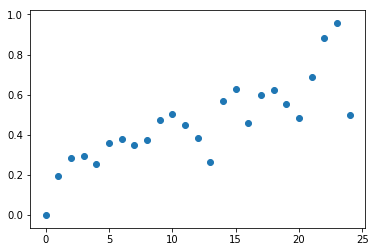

In [385]:
locations0 = pts.values.T
data = model.mean().values
#hs = np.linspace(0,.25, 50)/360*2*np.pi*r_earth
hs = np.linspace(0,25,26)
bandwidth =1# np.abs(hs[1]-hs[0])

N = data.shape[0]
semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
for h in hs:
    Z = []
    for i in range(N): 
        for j in range(i+1,N): 
            #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
            distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
            if (distance >= h) and (distance< h+bandwidth):
#            if (distance[i,j] >= h-bandwidth) and (distance[i,j]< h+bandwidth)
                Z.append(np.abs(data[i] - data[j])) 
    semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
plt.scatter(semivariogram.index, semivariogram.semivariogram)

In [437]:
lcc[(lcc.LCC>=25) & (lcc.LCC <=26)]

,LCC,LCC English
139,25.0,"Developed, Medium Intensity"
10,26.0,"Developed, High Intensity"
105,25.0,"Developed, Medium Intensity"
80,26.0,"Developed, High Intensity"
71,26.0,"Developed, High Intensity"
35,26.0,"Developed, High Intensity"
91,25.0,"Developed, Medium Intensity"
19,25.0,"Developed, Medium Intensity"
27,26.0,"Developed, High Intensity"
5,25.0,"Developed, Medium Intensity"


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in double_scalars


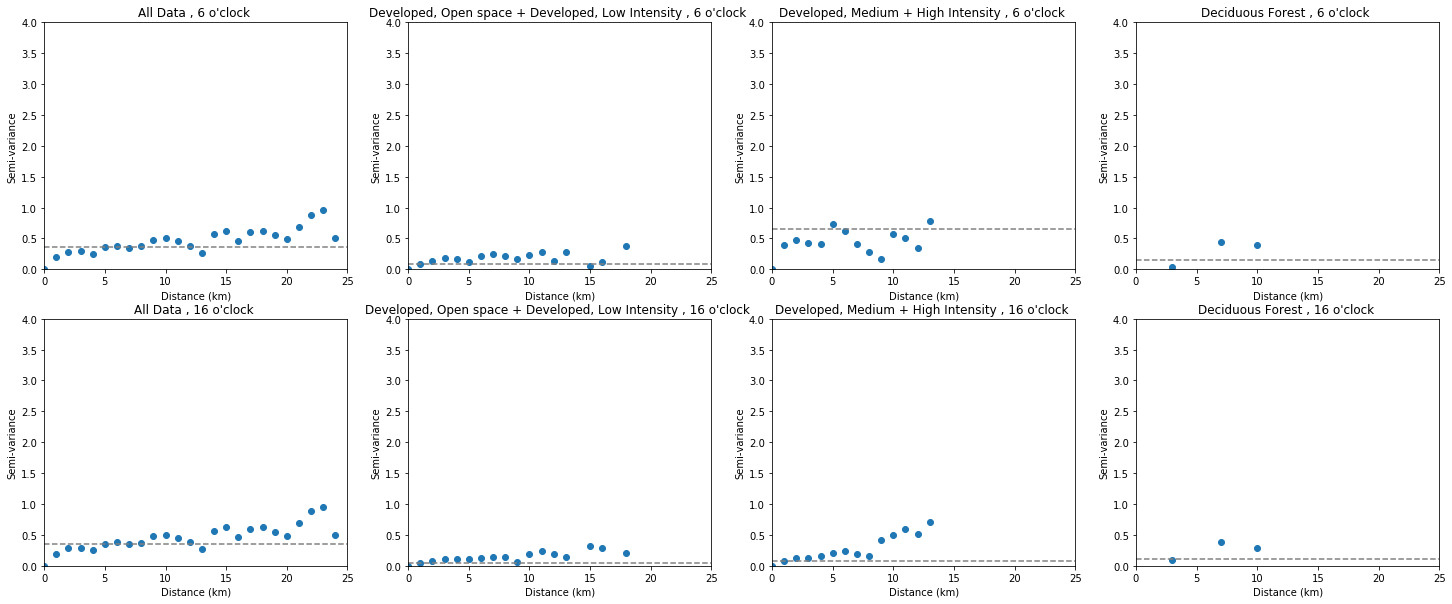

In [504]:
r_earth = 6371
pts_df = pts.T.to_pandas()
pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
 'Developed, Medium + High Intensity',
# 'Developed, High Intensity',
 'Deciduous Forest']
fig =plt.figure(figsize=[25,10])
iii = 1
for hr in [6,16]: 
    locations0 = pts_df.values
    data0 = model.mean().values
    
    locations1 = pts_df.loc[lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].values
    data1 =  model[model.index.hour==hr][lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].mean().values
    
#     locations2 = pts_df.loc[lcc[lcc.LCC ==24].index].values
#     data2 =  model[lcc[lcc.LCC ==24].index].mean().values
    
    locations3 = pts_df.loc[lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].values
    data3 =  model[model.index.hour==hr][lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].mean().values
    
#     locations4 = pts_df.loc[lcc[lcc.LCC ==26].index].values
#     data4 =  model[lcc[lcc.LCC ==26].index].mean().values
    
    locations5 = pts_df.loc[lcc[lcc.LCC ==28].index].values
    data5 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean().values
    
    hs = np.linspace(0,25,26)
    bandwidth =1# np.abs(hs[1]-hs[0])


    for data,locations,label in zip([data0,data1, data3, data5], [locations0,locations1,locations3,locations5], labels):
        N = data.shape[0]
        ax = plt.subplot(2,4,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram)
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        ax.set_ylim([0,4])
        ax.set_xlim([0,25])

        iii = iii+1
plt.savefig('figures/spatialvariability_model.png')

# Variability by landcover type


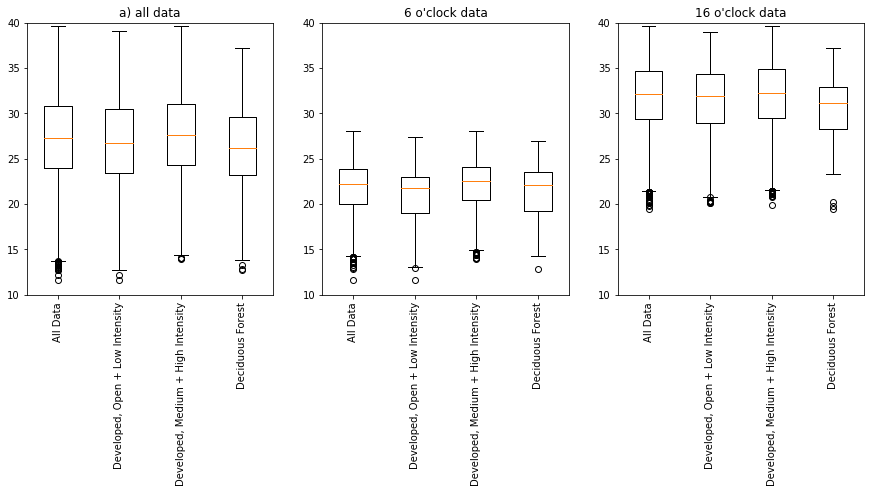

In [461]:
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,3,1)
# data = [model.mean().dropna().values.flatten(), # all data
#         model[lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].mean().values.flatten(),  #
#         model[lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].mean().values.flatten(), 
#         model[lcc[lcc.LCC ==28].index].mean().values.flatten()
#        ]
data = [model.dropna().values.flatten(), # all data
        model[lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].dropna().values.flatten(),  #
        model[lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].dropna().values.flatten(), 
        model[lcc[lcc.LCC ==28].index].dropna().values.flatten(),
       ]
labels = ['All Data', 'Developed, Open + Low Intensity',
 'Developed, Medium + High Intensity', 'Deciduous Forest']
handles = plt.boxplot(data,positions=[0,1,2,3])
labels = ax.set_xticklabels(labels, rotation='vertical')
ax.set_title('a) all data')
ax.set_ylim([10,40])
iii = 2
for hr in [6,16]: 
    ax = plt.subplot(1,3,iii)
#     data = [model[model.index.hour == hr].mean().dropna().values.flatten(), # all data
#         model[model.index.hour == hr][lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].mean().values.flatten(),  #
#         model[model.index.hour == hr][lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].mean().values.flatten(), 
#         model[model.index.hour == hr][lcc[lcc.LCC ==28].index].mean().values.flatten()
#        ]
    data = [model[model.index.hour == hr].dropna().values.flatten(), # all data
        model[model.index.hour == hr][lcc[(lcc.LCC>=23) & (lcc.LCC <=24)].index].dropna().values.flatten(),  #
        model[model.index.hour == hr][lcc[(lcc.LCC>=25) & (lcc.LCC <=26)].index].dropna().values.flatten(), 
        model[model.index.hour == hr][lcc[lcc.LCC ==28].index].dropna().values.flatten(),
       ]
    
    handles = plt.boxplot(data,positions=[0,1,2,3])
    labels = ax.set_xticklabels(labels,rotation='vertical')
    ax.set_title('%s o\'clock data'%hr)
    ax.set_ylim([10,40])
    iii =iii+1
plt.savefig('figures/landcover_boxplots_model.png')

# Change during warmer periods


In [485]:
from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5, one_to_one_line = False) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        if one_to_one_line: 
            plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

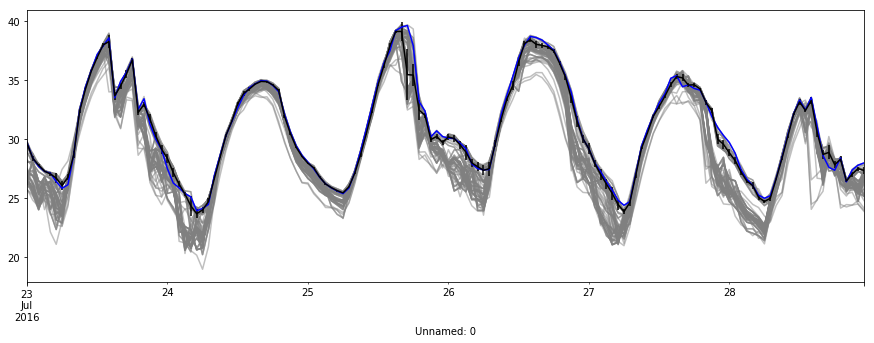

In [480]:
model['2016-07-23':'2016-07-28'].plot(figsize = [15,5],legend = False, color = 'grey', alpha = .5,zorder =1)
model['2016-07-23':'2016-07-28'][lcc[lcc.LCC==26].index].mean(axis=1).plot(color = 'black', zorder = 2, yerr = model['2016-07-23':'2016-07-28'][lcc[lcc.LCC==26].index].std(axis=1))
#model['2016-07-23':'2016-07-28'][97].plot(yerr = tempDF['2016-07-23':'2016-07-28'].std(axis=1), 
#                                           linewidth = 3, color = 'k', zorder = 2)
model['2016-07-23':'2016-07-28'][97].plot(color = 'blue')

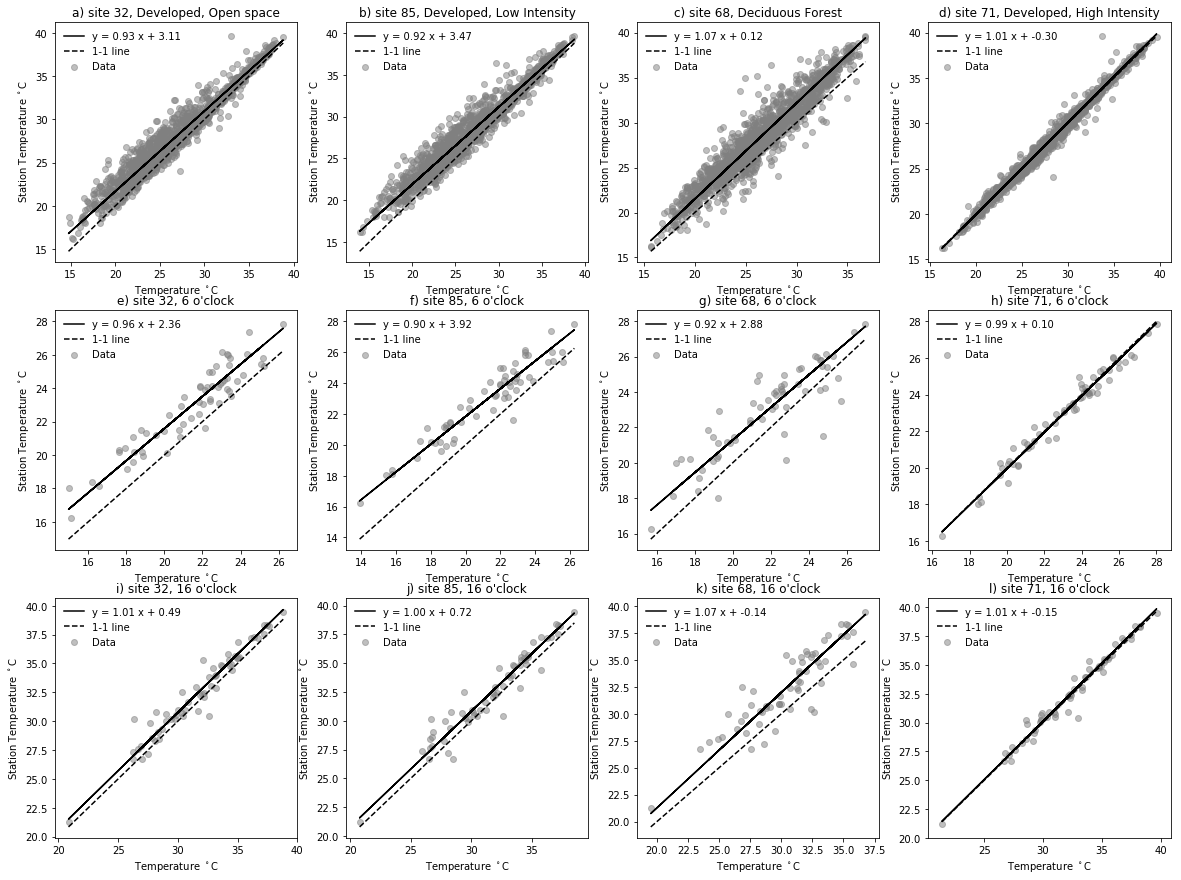

In [516]:
selected = [97,32,85,68, 
           #66, # hot but right next to sci center
            #86,
            #126,
            71,
            #100,#78, 66,86,
           ]
selected_labels = pd.DataFrame(['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City'], columns=['label'], index = selected, )
selected_labels = lcc.loc[selected]['LCC English']
fig = plt.figure(figsize=[5*(len(selected)-1),15])
iii = 1
for ind in selected[1:]: 
    ax = plt.subplot(3,len(selected)-1,iii) 
    b0,b1, r,p = easy_scatter_tls(model[ind], model[97], 
                 '%s) site %i, %s'%(string.ascii_lowercase[iii-1], ind, selected_labels.loc[ind]), 'Temperature $^\circ $C',' Station Temperature $^\circ $C',one_to_one_line=True)
    iii = iii+1

for hr in [6,16]: 
    for ind in selected[1:]: 
        ax = plt.subplot(3,len(selected)-1,iii) 
        b0,b1, r,p = easy_scatter_tls(model[model.index.hour==hr][ind], model[model.index.hour==hr][97], 
                     '%s) site %i, %s o\'clock'%(string.ascii_lowercase[iii-1],ind,hr),
                                      'Temperature $^\circ $C','Station Temperature $^\circ $C',one_to_one_line=True)
        iii = iii+1
plt.savefig('figures/heat_model.png')

In [492]:
lcc.loc[selected]['LCC English'].values

array(['Developed, High Intensity', 'Developed, Open space',
       'Developed, Low Intensity', 'Deciduous Forest',
       'Developed, High Intensity'], dtype=object)

## Synoptic weather type 

In [549]:
# import data to classify dry days and wet days 
file =  'data/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-07-01': '2016-08-31'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

In [509]:
meta.loc[4]

sensornumber                                                          4
meta:instanceID               uuid:22e80842-6a7d-482a-8785-321ee28a0936
oldsensornumber                                                       4
location:Latitude                                               39.3584
location:Longitude                                             -76.6572
location:Altitude                                                    53
location:Accuracy                                                     5
direction                                                             0
sunorshade                                                        shade
attachment                                                         tree
landcoverclass                                                     dirt
vesasitenumber                                                       18
vesacategory                                                          f
picture               https://bmorecoolodk.appspot.com/view/bina

In [ ]:
68, 75, 103, 121,130, 63, 4

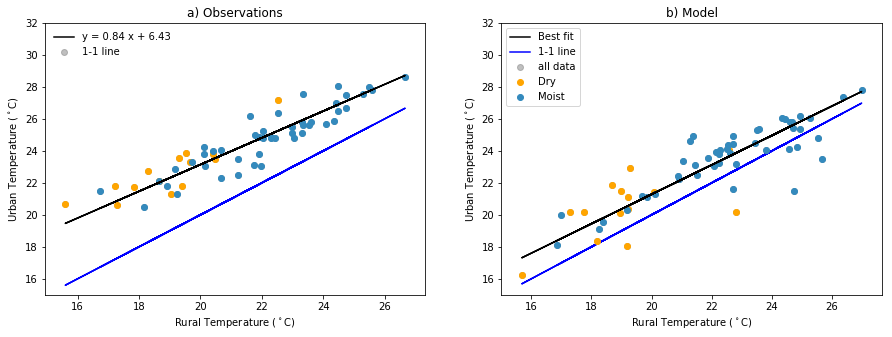

In [560]:
# urban = 97
# rural = 75
urban = 97 #97 # science center
rural = 68 #68 # darryn's house

dry_temp = tempDF[rural][syn[syn <=3].index].dropna()
moist_temp = tempDF[rural][syn[syn > 3].index].dropna()

plt.figure(figsize = [15,5])
ax = plt.subplot(1,2,1)
hour = 6
easy_scatter_tls(tempDF[rural][tempDF.index.hour ==hour ] , tempDF[urban][tempDF.index.hour ==hour ],
             'Observations', 
             'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
plt.plot(tempDF[rural][tempDF.index.hour ==hour ], tempDF[rural][tempDF.index.hour ==hour ], color = 'blue', zorder =0)
# plot dry 
plt.scatter(tempDF[rural].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], 
           tempDF[urban].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], color = 'orange')
# plot moist
plt.scatter(tempDF[rural].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], 
          tempDF[urban].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], color = u'#348ABD')
ax.set_title('a) Observations')
#plt.legend(['Best fit', '1-1 line', 'other 1-1 line', 'all data', 'Dry', 'Moist'], loc = 2)
ax.set_ylim([15,32])

ax=plt.subplot(1,2,2)
easy_scatter_tls(model[model.index.hour==6][rural], model[model.index.hour==6][urban], 'b) Model', 
             'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
plt.plot(model[model.index.hour==6][rural],model[model.index.hour==6][rural], 'blue', zorder = 0)
# plot dry 
plt.scatter(model[rural].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], 
           model[urban].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], color = 'orange')
# plot moist
plt.scatter(model[rural].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], 
          model[urban].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], color = u'#348ABD')

plt.legend(['Best fit', '1-1 line', 'all data', 'Dry', 'Moist'], loc = 2)
ax.set_ylim([15,32])
plt.savefig('figures/synoptic_6am.png')

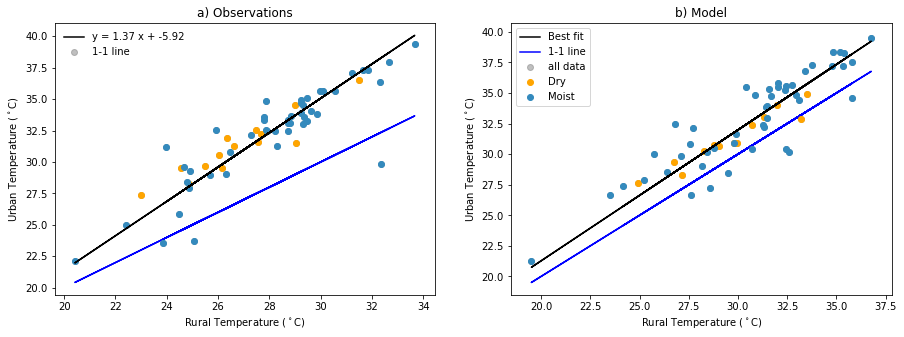

In [561]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,2,1)
hour = 16
easy_scatter_tls(tempDF[rural][tempDF.index.hour ==hour ] , tempDF[urban][tempDF.index.hour ==hour ],
             'Observations', 
             'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
plt.plot(tempDF[rural][tempDF.index.hour ==hour ], tempDF[rural][tempDF.index.hour ==hour ], color = 'blue', zorder =0)
# plot dry 
plt.scatter(tempDF[rural].loc[syn[syn <=3].index + pd.Timedelta('16:00:00')], 
           tempDF[urban].loc[syn[syn <=3].index + pd.Timedelta('16:00:00')], color = 'orange')
# plot moist
plt.scatter(tempDF[rural].loc[syn[syn >3].index + pd.Timedelta('16:00:00')], 
          tempDF[urban].loc[syn[syn >3].index + pd.Timedelta('16:00:00')], color = u'#348ABD')
ax.set_title('a) Observations')
#plt.legend(['Best fit', '1-1 line', 'other 1-1 line', 'all data', 'Dry', 'Moist'], loc = 2)
#ax.set_ylim([15,32])

ax=plt.subplot(1,2,2)
easy_scatter_tls(model[model.index.hour==hour][rural], model[model.index.hour==hour][urban], 'b) Model', 
             'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
plt.plot(model[model.index.hour==hour][rural],model[model.index.hour==hour][rural], 'blue', zorder = 0)
# plot dry 
plt.scatter(model[rural].loc[syn[syn <=3].index + pd.Timedelta('16:00:00')], 
           model[urban].loc[syn[syn <=3].index + pd.Timedelta('16:00:00')], color = 'orange')
# plot moist
plt.scatter(model[rural].loc[syn[syn >3].index + pd.Timedelta('16:00:00')], 
          model[urban].loc[syn[syn >3].index + pd.Timedelta('16:00:00')], color = u'#348ABD')

plt.legend(['Best fit', '1-1 line', 'all data', 'Dry', 'Moist'], loc = 2)
#ax.set_ylim([15,32])
plt.savefig('figures/synoptic_16pm.png')